In [1]:
from astropy.io import fits
import pyregion
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as cte 
import regions
from astropy.wcs import WCS
import cmasher as cm
import seaborn as sn
from discrete_gaussian_model import DiscreteGaussianModel
from astropy.nddata import Cutout2D
from astropy.coordinates import Angle
from astropy.modeling import models, fitting
from astropy.modeling.models import Const1D
from astropy.table import QTable, Table
from astropy.coordinates import SkyCoord
FITTER = fitting.LevMarLSQFitter()

# radios de la parte neutra

Primero vamos a leer los radios de la parte neutra calculados con el combo-E

In [3]:
r0 = QTable.read('r0.ecsv')
r0

PA,Sep,Bcore,Bbg,Rcore
deg,arcsec,,,arcsec
float64,float64,float64,float64,float64
296.28,2.98,6.28,1.50,0.09
66.87,3.15,15.00,3.98,0.12
30.92,3.31,1.19,2.06,0.20
71.97,3.52,15.00,2.43,0.13
16.83,3.80,8.04,2.89,0.07
57.69,4.38,3.74,1.32,0.16
...,...,...,...,...
88.55,30.80,0.47,0.59,0.08


In [4]:
dfr0 = r0.to_pandas()

dfr0.describe()

,PA,Sep,Bcore,Bbg,Rcore
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,168.106302,16.980575,4.058819,0.333250,0.125980
std,98.237666,7.119153,3.626326,0.601029,0.038028
min,0.869823,2.984176,0.004973,-1.998649,0.063527
25%,84.269909,11.526672,1.231055,0.078173,0.099840
50%,179.449531,16.476920,2.835553,0.293442,0.120000
75%,220.171022,21.928773,5.905616,0.531138,0.145324
max,359.624454,35.096384,14.999991,3.981192,0.271989


Text(0.5, 1.0, 'solo radios')

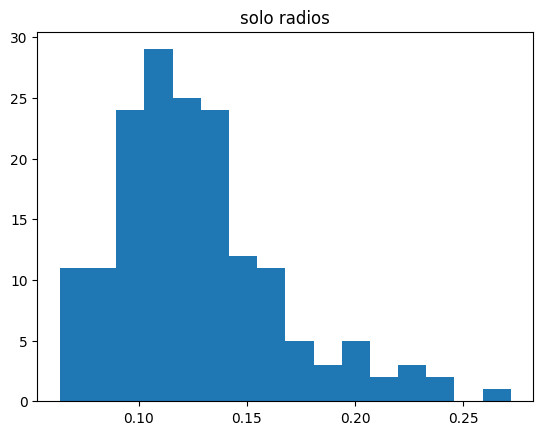

In [9]:
plt.hist(dfr0['Rcore'],bins=16)
plt.title('solo radios')

Ahora vamos a considerar la anchura media y el ancho del telescopio 

Text(0.5, 1.0, 'radios neutros corregidos')

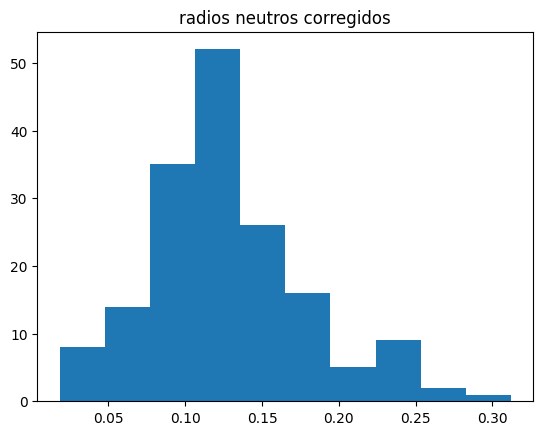

In [8]:
r_FJ = 2*np.sqrt(2*np.log(2))*dfr0['Rcore']
r_CJ = (np.sqrt(r_FJ**2-.145**2))/2
#r_CH = np.sqrt(r_FH**2-.067**2)
plt.hist(r_CJ)
plt.title('radios neutros corregidos')

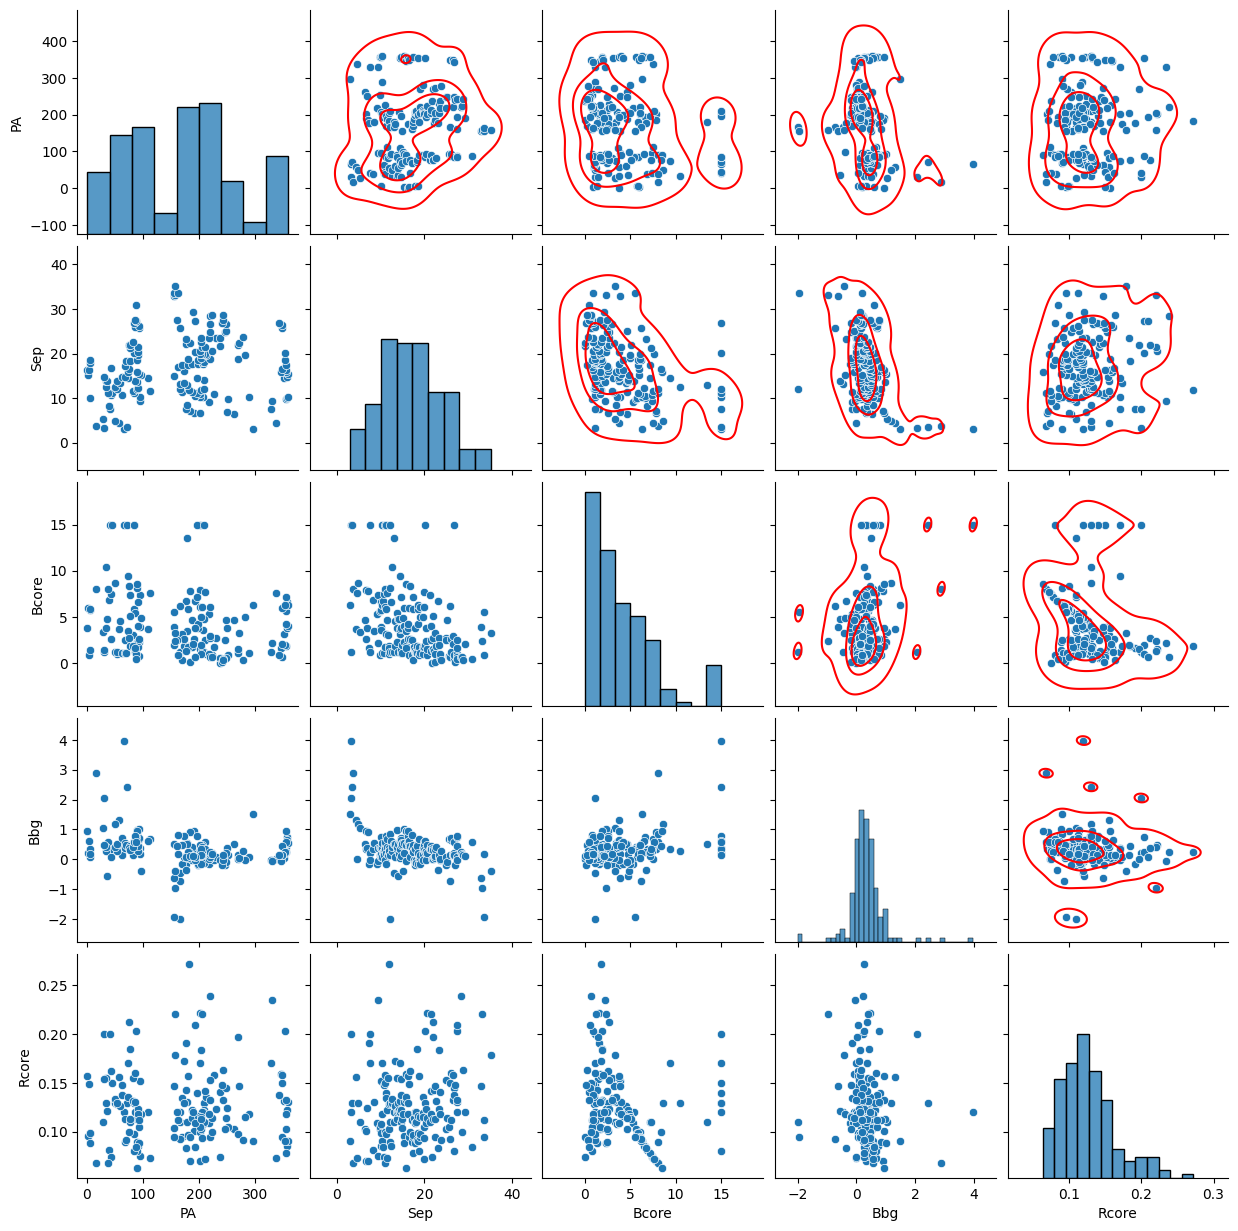

In [10]:
g = sn.pairplot(dfr0, dropna=True)
g.map_upper(sn.kdeplot, levels=4, color='r')

Text(0, 0.5, 'r_0')

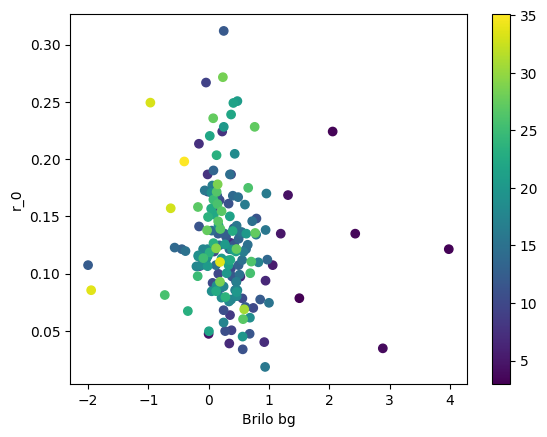

In [20]:
g = plt.scatter(dfr0['Bbg'],r_CJ,c=dfr0['Sep'])
plt.colorbar(g)
plt.xlabel('Brilo bg')
plt.ylabel('r_0')

De esta grafica vemos que en principio que el brillo de fondo se mantiene mas o menos constante a todos los radios medidos para la parte neutra.

Cabe mencionar que se arregló el radio de 30 glóbulos, por lo que puede que algunos puntos que están muy dispersos pueden ser de estos 30 glóbulos.

Text(0, 0.5, 'r_0')

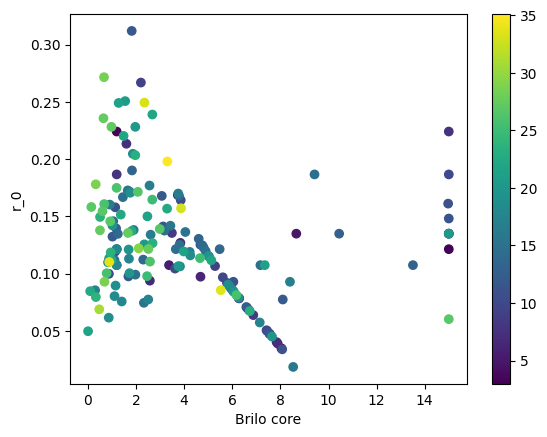

In [21]:
g = plt.scatter(dfr0['Bcore'],r_CJ,c=dfr0['Sep'])
plt.colorbar(g)
plt.xlabel('Brilo core')
plt.ylabel('r_0')

# Datos con HST

primero vamos a comparar con los radios de la parte neutra

In [15]:
HST = QTable.read('m1-67-globule-parameters.ecsv')
HST

PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell,Group,Lat
deg,arcsec,,,,arcsec,arcsec,arcsec,,deg
float64,float64,float64,float64,float64,float64,float64,float64,object,float64
296.28,2.98,0.32,0.25,0.49,0.05,nan,0.14,None,71.28
66.87,3.15,nan,nan,0.73,nan,1.10,nan,NE-04,21.87
30.92,3.31,1.17,0.41,0.91,0.14,0.45,0.16,NE-04,14.08
71.97,3.52,0.54,nan,0.54,0.10,nan,nan,NE-04,26.97
16.83,3.80,0.64,nan,0.82,0.09,nan,nan,NE-04,28.17
57.69,4.38,0.14,nan,0.45,0.06,1.45,nan,NE-04,12.69
...,...,...,...,...,...,...,...,...,...
88.55,30.80,0.06,nan,0.06,0.08,0.55,0.08,E-27,43.55


In [16]:
dfhst = HST.to_pandas()

dfhst.describe()

,PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell,Lat
count,168.000000,168.000000,154.000000,116.000000,168.000000,151.000000,97.000000,120.000000,168.000000
mean,168.106302,16.980575,0.461597,0.291308,0.303298,0.136603,0.548037,0.345173,34.486506
std,98.237666,7.119153,0.277853,0.206712,0.213673,0.048809,0.243158,0.189154,19.136906
min,0.869823,2.984176,0.062834,0.037752,0.000000,0.033527,0.101611,0.076756,0.794354
25%,84.269909,11.526672,0.247837,0.145399,0.135290,0.103565,0.399095,0.211479,18.452669
50%,179.449531,16.476920,0.398868,0.220749,0.262336,0.128829,0.531826,0.284617,37.267109
75%,220.171022,21.928773,0.640780,0.411397,0.444428,0.168491,0.685827,0.417208,48.026525
max,359.624454,35.096384,1.260578,0.933158,1.117983,0.307342,1.451368,0.976347,75.098656


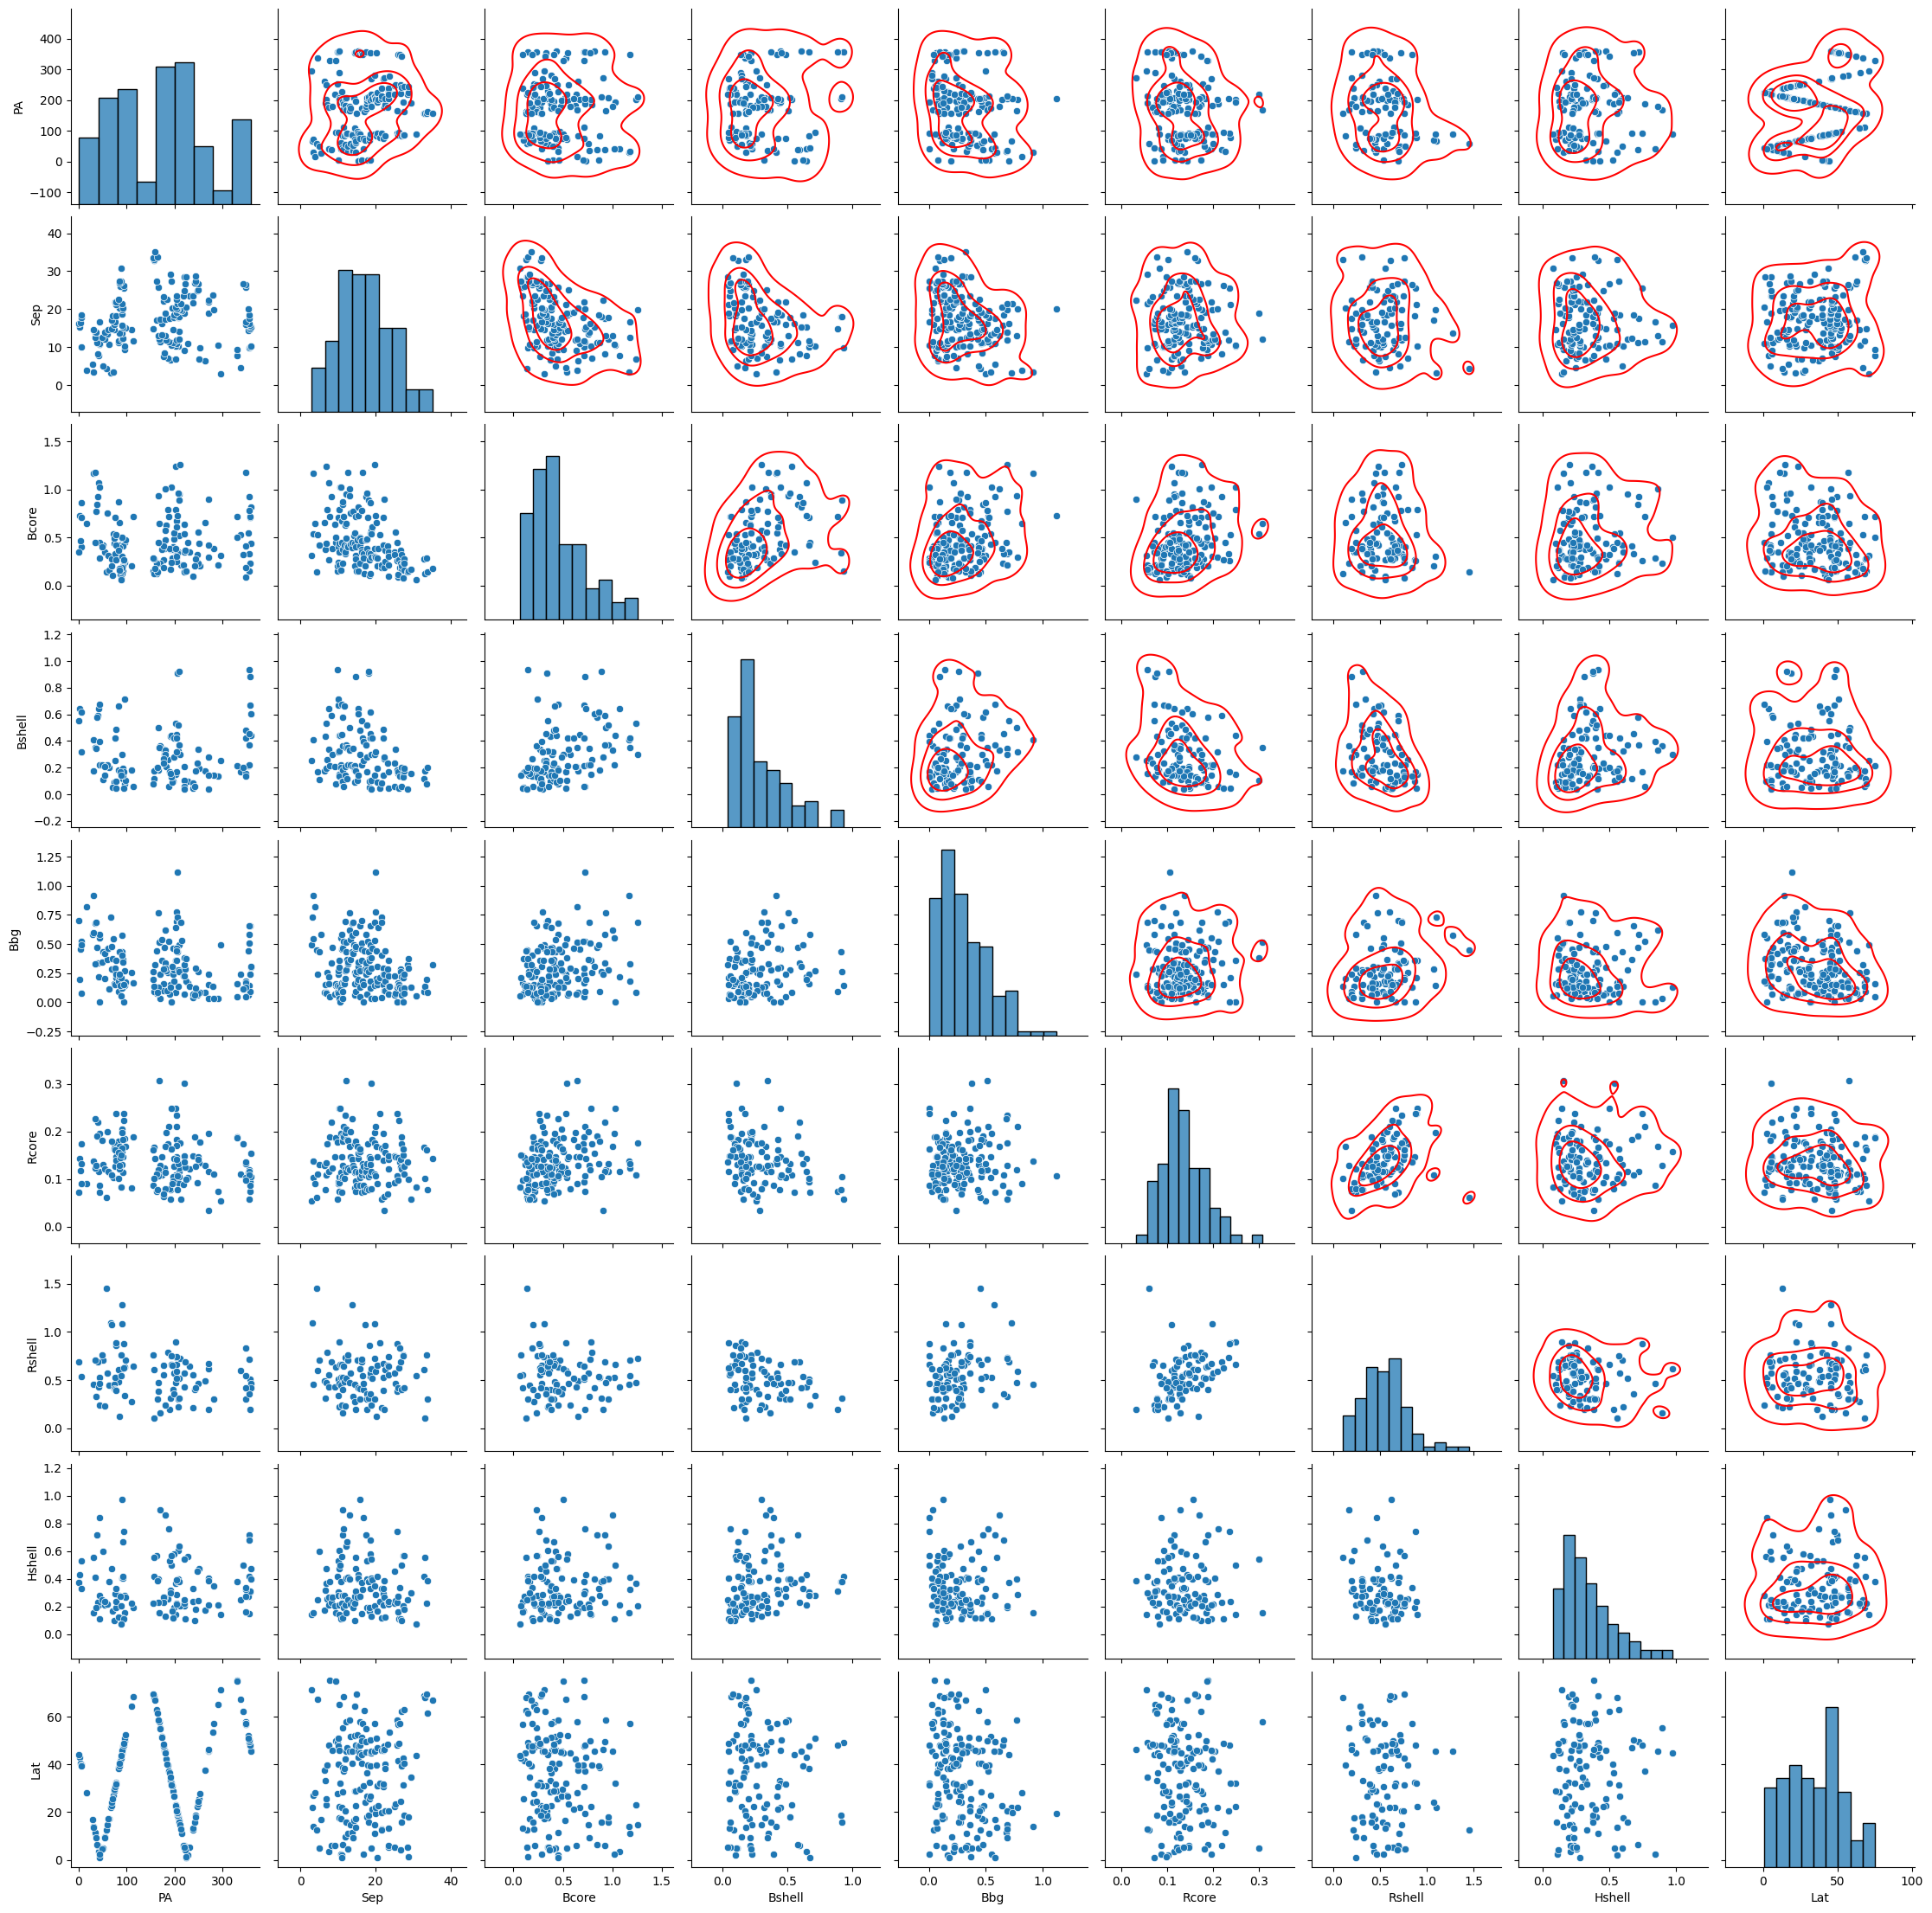

In [29]:
g = sn.pairplot(dfhst, dropna=True)
g.map_upper(sn.kdeplot, levels=4, color='r')

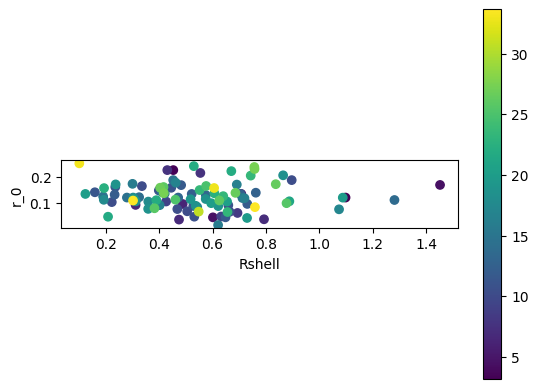

In [22]:
g = plt.scatter(dfhst['Rshell'],r_CJ,c=dfhst['Sep'])
plt.colorbar(g)
plt.xlabel('Rshell')
plt.ylabel('r_0')
plt.gca().set_aspect('equal')

En la anterior imagen vemos $r_0 - r_1$ que pareciera ser una constante, pero recordemos que algunas cáscaras detectadas con HST están mal, así que ahora veremos solo con unas cascaras seleccionadas

In [78]:
Sel_HST = [
    2,6,9,13,14,15,17,28,32,35,43,51,52,72,82,100,111,125,127,133,135,141,143,144,147,153,156
]

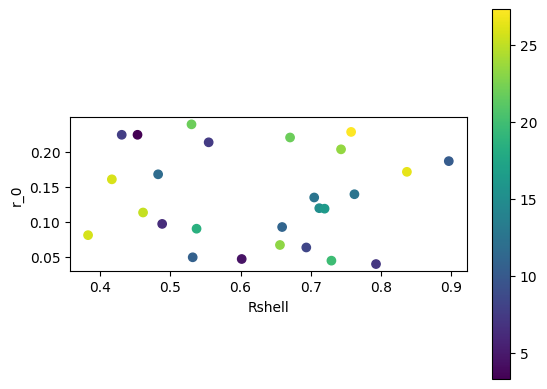

In [24]:
g = plt.scatter(dfhst['Rshell'][Sel_HST],r_CJ[Sel_HST],c=dfhst['Sep'][Sel_HST])
plt.colorbar(g)
plt.xlabel('Rshell')
plt.ylabel('r_0')
plt.gca().set_aspect('equal')

Text(0.5, 1.0, 'distribución de r_1/r_0 con r_1 de HST')

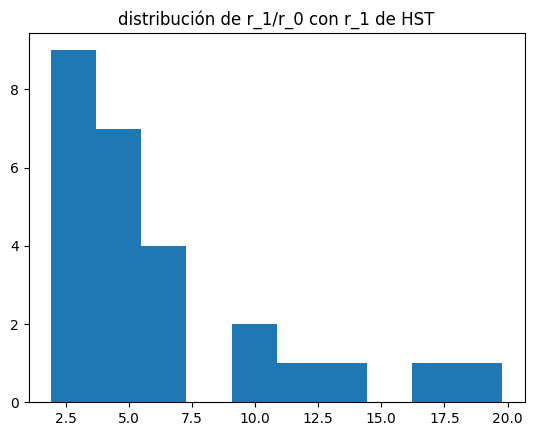

In [35]:
x = dfhst['Rshell'][Sel_HST]/r_CJ[Sel_HST]
plt.hist(x)
plt.title('distribución de r_1/r_0 con r_1 de HST')

# Datos con JWST

Ahora veremos las cáscaras solo con la el combo E que es el gas ionizado

In [27]:
JWST = QTable.read('JWST-combo-E.ecsv')
JWST

PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell
deg,arcsec,,,,arcsec,arcsec,arcsec
float64,float64,float64,float64,float64,float64,float64,float64
296.28,2.98,5.47,0.80,10.57,0.14,0.10,1.00
66.87,3.15,2.48,2.50,5.95,0.09,0.56,0.32
30.92,3.31,7.29,0.80,9.36,0.11,0.10,1.00
71.97,3.52,0.01,0.01,8.98,0.01,0.10,0.01
16.83,3.80,4.93,2.43,5.96,0.11,0.75,0.25
57.69,4.38,1.64,0.01,3.81,0.09,0.79,0.01
...,...,...,...,...,...,...,...
88.55,30.80,0.49,0.01,1.73,0.10,0.10,0.01


In [28]:
dfjw = JWST.to_pandas()

dfjw.describe()

,PA,Sep,Bcore,Bshell,Bbg,Rcore,Rshell,Hshell
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,168.106302,16.980575,2.610087,1.224425,3.060817,0.139028,0.463452,0.399321
std,98.237666,7.119153,1.611187,1.214343,1.772693,0.070201,0.428909,0.324161
min,0.869823,2.984176,0.010000,0.000399,0.481741,0.010000,0.100000,0.010000
25%,84.269909,11.526672,1.432847,0.276065,1.844773,0.101112,0.100000,0.194069
50%,179.449531,16.476920,2.227768,1.018797,2.645717,0.129565,0.364647,0.306526
75%,220.171022,21.928773,3.754178,1.770013,3.977039,0.154981,0.641804,0.487199
max,359.624454,35.096384,7.293658,9.232892,10.566352,0.500000,1.500000,1.000000


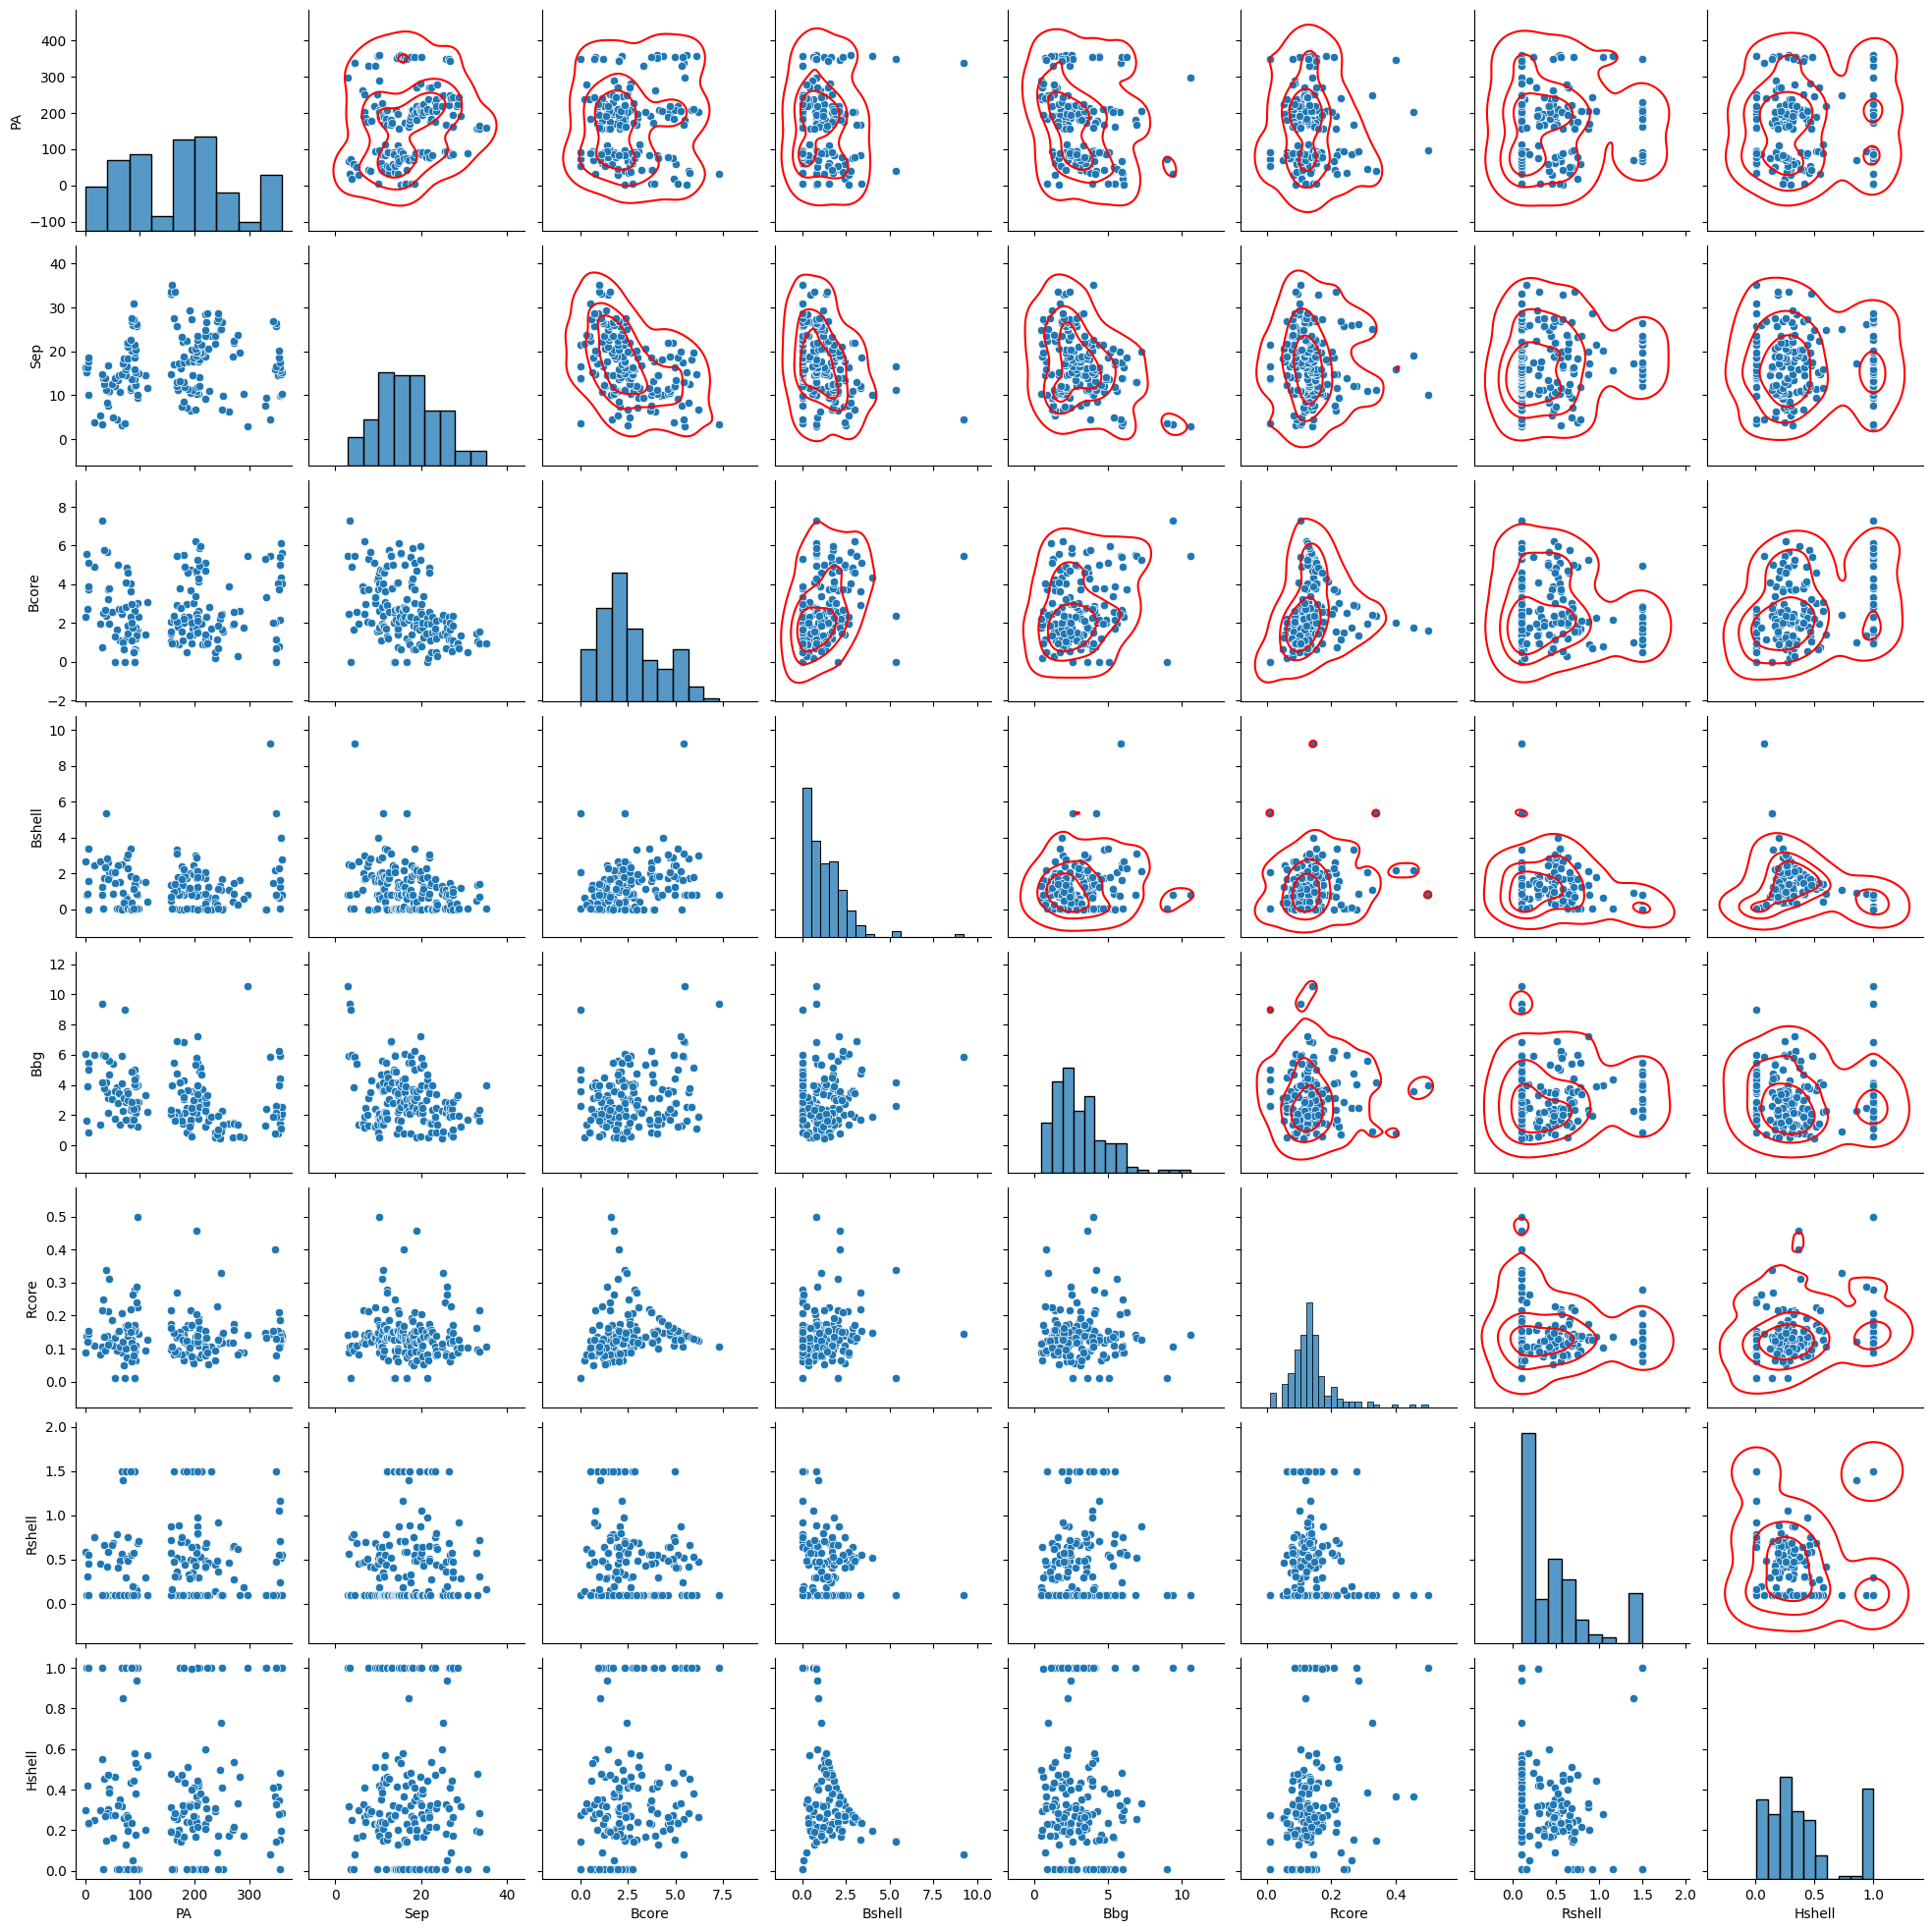

In [30]:
g = sn.pairplot(dfjw, dropna=True)
g.map_upper(sn.kdeplot, levels=4, color='r')

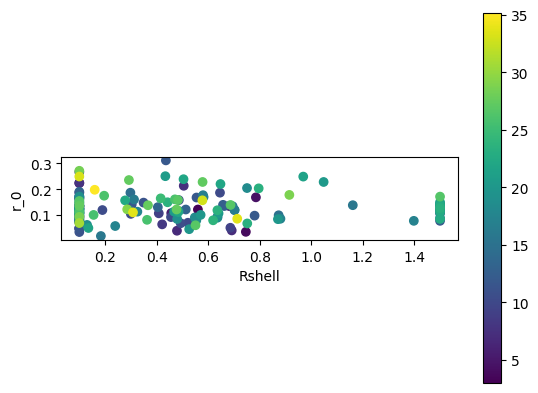

In [31]:
g = plt.scatter(dfjw['Rshell'],r_CJ,c=dfjw['Sep'])
plt.colorbar(g)
plt.xlabel('Rshell')
plt.ylabel('r_0')
plt.gca().set_aspect('equal')

Nuevamente vamos a tomar solo unos seleccionados para comparar el radio de la cáscara con el de la parte neutra

In [110]:
Sel_jw = [
    8,9,11,13,14,24,28,31,35,38,43,52,71,80,82,100,117,118,125,127,135,138,143,144,152,153,156
]

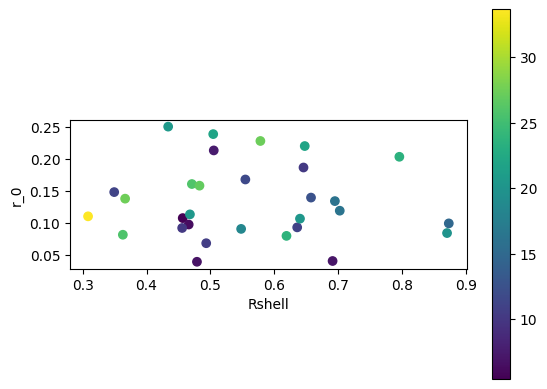

In [48]:
g = plt.scatter(dfjw['Rshell'][Sel_jw],r_CJ[Sel_jw],c=dfjw['Sep'][Sel_jw])
plt.colorbar(g)
plt.xlabel('Rshell')
plt.ylabel('r_0')
plt.gca().set_aspect('equal')

Text(0.5, 1.0, 'distribución de r_1/r_0 con r_1 de JWST')

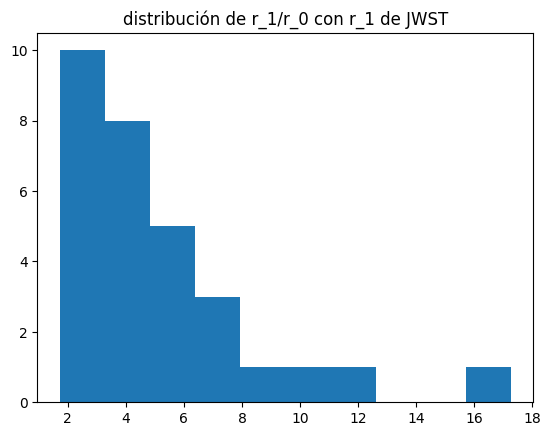

In [49]:
x = dfjw['Rshell'][Sel_jw]/r_CJ[Sel_jw]
plt.hist(x)
plt.title('distribución de r_1/r_0 con r_1 de JWST')

# Comparación de Rshell y Hshell 

Vamos a comprar los valores de los radios de las cáscaras y de sus anchos con los diferentes telescopios

In [37]:
comun = []
for i in Sel_jw:
    if i in Sel_HST:
        comun.append(i)

comun

[9, 13, 14, 28, 35, 43, 52, 82, 100, 125, 127, 135, 143, 144, 153]

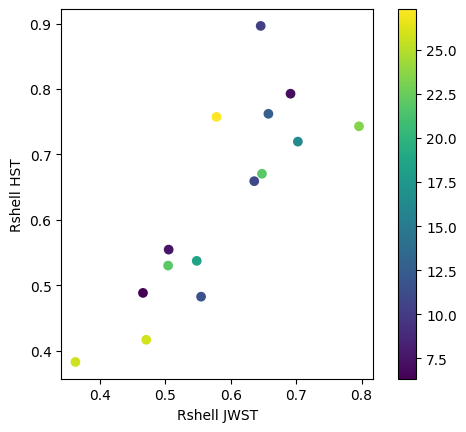

In [38]:
g = plt.scatter(dfjw['Rshell'][comun],dfhst['Rshell'][comun],c=dfjw['Sep'][comun])
plt.colorbar(g)
plt.xlabel('Rshell JWST')
plt.ylabel('Rshell HST')
plt.gca().set_aspect('equal')

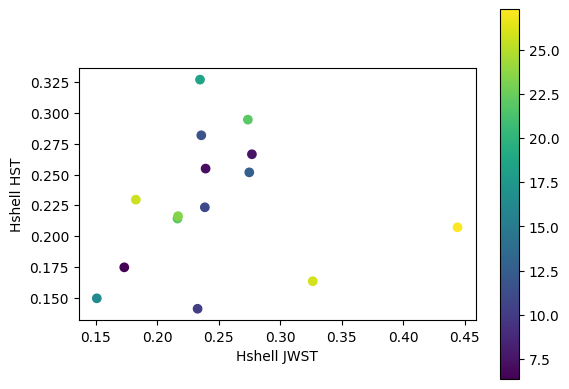

In [40]:
g = plt.scatter(dfjw['Hshell'][comun],dfhst['Hshell'][comun],c=dfjw['Sep'][comun])
plt.colorbar(g)
plt.xlabel('Hshell JWST')
plt.ylabel('Hshell HST')
plt.gca().set_aspect('equal')

En ambos parece ser que las mediciones tanto de la cáscara como su ancho son iguales. 

En el ancho parece ser que dos de los puntos que se salen de esta tendencia son glóbulos que están lejanos de la estrella.

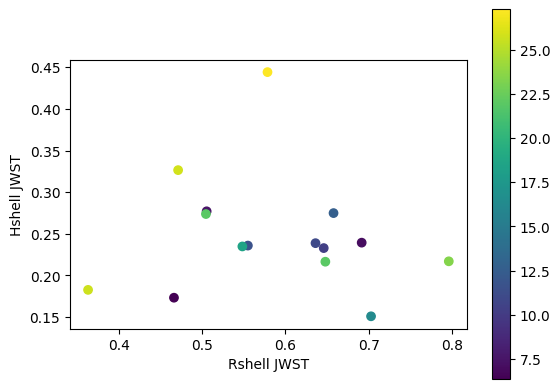

In [43]:
g = plt.scatter(dfjw['Rshell'][comun],dfjw['Hshell'][comun],c=dfjw['Sep'][comun])
plt.colorbar(g)
plt.xlabel('Rshell JWST')
plt.ylabel('Hshell JWST')
plt.gca().set_aspect('equal')

Text(0.5, 1.0, 'globulos en los que tmabien se detecto una cáscara en JWST')

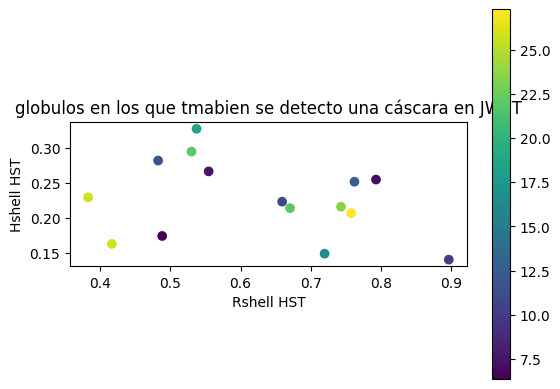

In [45]:
g = plt.scatter(dfhst['Rshell'][comun],dfhst['Hshell'][comun],c=dfjw['Sep'][comun])
plt.colorbar(g)
plt.xlabel('Rshell HST')
plt.ylabel('Hshell HST')
plt.gca().set_aspect('equal')
plt.title('globulos en los que tmabien se detecto una cáscara en JWST')

Text(0.5, 1.0, 'globulos en los que solo se detecto cascara en HST')

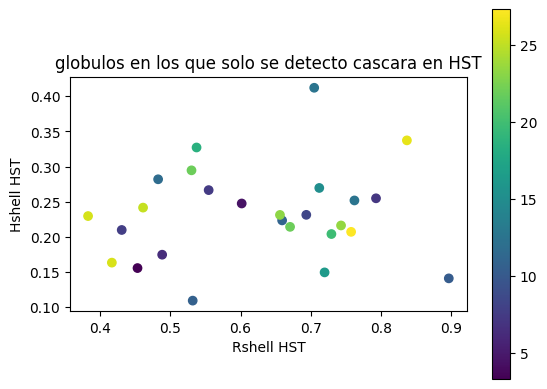

In [46]:
g = plt.scatter(dfhst['Rshell'][Sel_HST],dfhst['Hshell'][Sel_HST],c=dfjw['Sep'][Sel_HST])
plt.colorbar(g)
plt.xlabel('Rshell HST')
plt.ylabel('Hshell HST')
plt.gca().set_aspect('equal')
plt.title('globulos en los que solo se detecto cascara en HST')

Con esto tenemos una muestra de 15 glóbulos que están mas o menos bien. Con lo encontrado anteriormente vamos incluir otras muestras en las que se detecta solo en el combo E, y vamos a tratar de encontrar su brillo en su cáscara para tener una estimación de su densidad y presión para aumentar la muestra.

In [111]:
''' Globulos a agregar  '''
add = [
    8,11,24,31,38,71,80,117,118,138,152
]

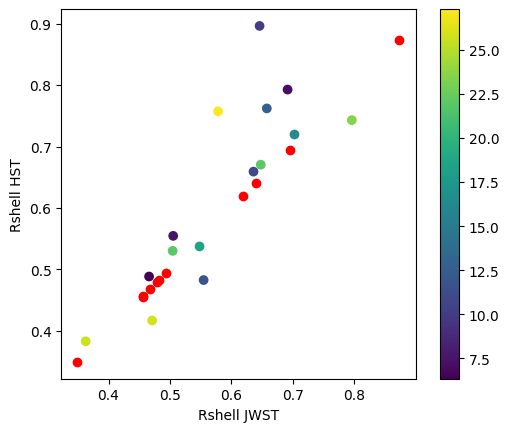

In [112]:
g = plt.scatter(dfjw['Rshell'][comun],dfhst['Rshell'][comun],c=dfjw['Sep'][comun])
plt.colorbar(g)
plt.scatter(dfjw['Rshell'][add],dfjw['Rshell'][add],color='r')
plt.xlabel('Rshell JWST')
plt.ylabel('Rshell HST')
plt.gca().set_aspect('equal')

Ahora checamos sus brillos en la cáscara con los radios obtenidos en el combo E, para esto se descartaron unos glóbulos en los cuales no estaba claro su cáscara. Cabe mencionar que en algunos casos si se detectaba una cáscara pero esa estaba mal en cuanto a su ancho, por lo que $Hshell$ estaba mla calculada o simplemente el código no la detectaba

In [113]:
Bshell_add = [
    .5,.625,.4,.55,.55,.33,.5,.4,.29,.11,.14
]

In [114]:
len(add)==len(Bshell_add)

True

# Trabajo con los globulos seleccionados y recuperados

Ahora con estos globulos vamos estimar densidades, presiones y angulos de corrección

In [115]:
glo = []
for i in Sel_jw:
    glo.append(i)

for i in Sel_HST:
    if i not in glo:
        glo.append(i)

for i in add:
    if i not in glo:
        glo.append(i)

Glo = sorted(glo)

In [116]:
R1 = []
for i in Glo:
    if i in Sel_jw:
        R1.append(dfjw['Rshell'][i])
    elif i in Sel_HST:
        R1.append(dfhst['Rshell'][i])

H = []
for i in Glo:
    if i in Sel_jw:
        H.append(dfjw['Hshell'][i])
    elif i in Sel_HST:
        H.append(dfhst['Hshell'][i])

Bs = []
for i in Glo:
    if i in Sel_HST:
        Bs.append(dfhst['Bshell'][i])
    elif i in add:
        Bs.append(Bshell_add[add.index(i)])

In [117]:
len(Glo)

38

Ahora tenemos una muestra de 39 globulos a los cuales ahora su densidad, presion y angulo de incinacion

In [118]:
'''   Densidad   '''
D = 5429*u.pc                      # conversation with Jane
v_inf = 710*u.km*(1/u.second)      # Hanmman
M_loss = (2.0E-5)*u.M_sun*(1/u.yr) #Crowther 1999
L = 10**(49.1)*(1/u.second)        # Hanmman

E = (cte.h*cte.c/(6562.8*u.AA)).cgs
EM = np.array(Bs)*4*np.pi*0.0137/(1.17e-13*E.value*u.cm**5)
n  = np.sqrt(EM/(2*np.sqrt(2*np.array(R1)*np.array(H)*D.value**2*u.AU**2))).cgs
n

<Quantity [1804.07251914,  970.54054918, 1694.89027505, 1139.57441135,
           1930.81577046, 1168.75634137, 1378.2725053 , 2127.39853274,
           1771.23557423, 1615.56037367,  895.72723962, 1836.72088746,
           1396.04908153, 1556.21385043, 2077.28224794, 1969.54049368,
           1172.09341189, 1047.58393118, 1153.79598212,  711.27699819,
           1834.20516231, 1198.18950001, 1909.05359581, 1277.61656378,
           1294.22225956, 1329.22779472, 1549.61361567,  907.70304385,
           1120.32608325,  928.64666255,  715.82773967, 1467.0245893 ,
           1219.47809883,  915.30809376,  733.20308777, 1186.07391098,
            780.52975319, 1219.86339232] 1 / cm3>

In [119]:
'''   Presion   '''
cs2 = (cte.k_B*6000*u.K/(0.6*cte.m_p)).to('km**2/s**2')
Pg = (n*cte.m_p*cs2).cgs
Pr = ((M_loss*v_inf)/(4*np.pi*((HST['Sep'][Glo].value*D.value)*u.AU)**2)).cgs

In [120]:
'''   cos(i)   '''
cos = (Pg/Pr)**(2/5)

In [136]:
R = HST['Sep'][Glo]/cos

Ahora vamos a ver como se ven contra la presion RAM del viento

(1e-10, 6e-09)

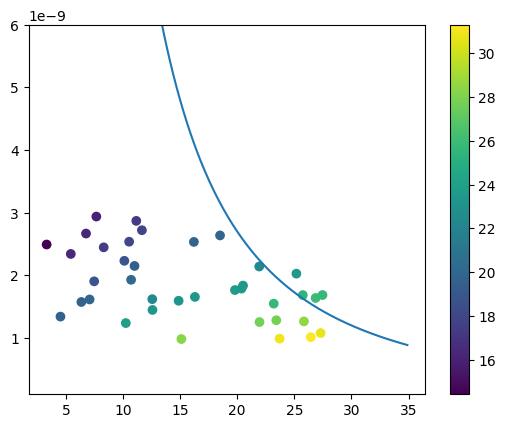

In [137]:
rang = np.arange(5,35,0.1) #the range in what we see the globules
distances = rang*D.value*u.AU
P_r = (M_loss*v_inf)/(4*np.pi*(distances.to('cm'))**2)
plt.plot(rang,P_r.cgs)
g = plt.scatter(HST['Sep'][Glo],Pg,c=R)
plt.colorbar(g)
plt.ylim(1e-10,0.6e-8)

(1e-10, 4e-08)

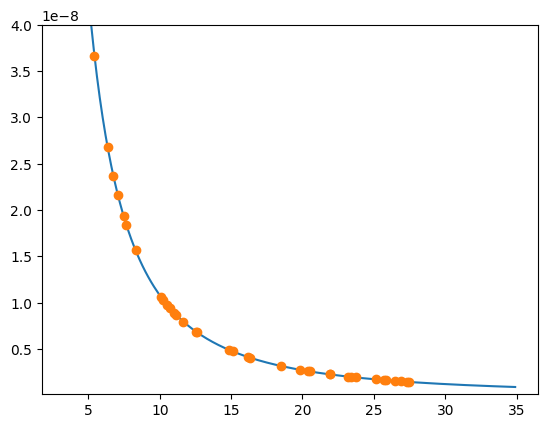

In [133]:
rang = np.arange(5,35,0.1) #the range in what we see the globules
distances = rang*D.value*u.AU
P_r = (M_loss*v_inf)/(4*np.pi*(distances.to('cm'))**2)
plt.plot(rang,P_r.cgs)
plt.plot(HST['Sep'][Glo],Pg/cos**(5/2),'o')
plt.ylim(1e-10,4e-8)

In [134]:
R = HST['Sep'][Glo]/cos

(array([2., 4., 5., 6., 2., 8., 4., 2., 2., 3.]),
 array([14.41213384, 16.10150806, 17.79088227, 19.48025648, 21.1696307 ,
        22.85900491, 24.54837912, 26.23775334, 27.92712755, 29.61650176,
        31.30587598]),
 <BarContainer object of 10 artists>)

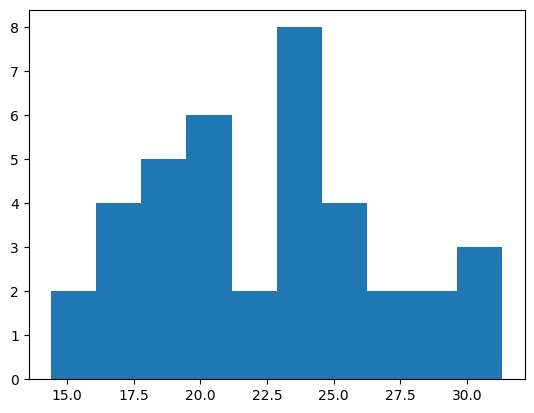

In [135]:
plt.hist(R)

# extras

1342.197734838573 1 / cm3 401.3013748187814 1 / cm3


(array([4., 5., 2., 9., 4., 3., 2., 4., 3., 2.]),
 array([ 711.27699819,  852.88915165,  994.5013051 , 1136.11345856,
        1277.72561201, 1419.33776547, 1560.94991892, 1702.56207238,
        1844.17422583, 1985.78637929, 2127.39853274]),
 <BarContainer object of 10 artists>)

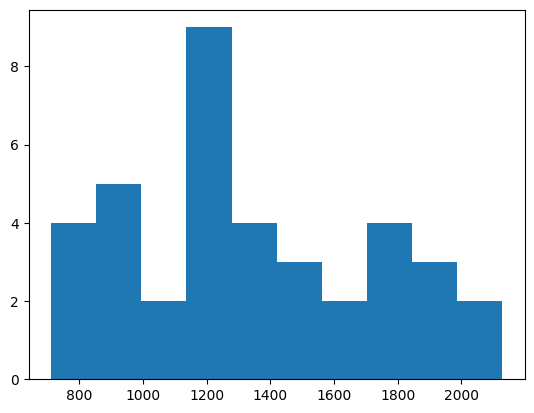

In [139]:
print(np.mean(n),np.std(n))
plt.hist(n)

1755.7076523376472 1 / cm3 708.1230433494298 1 / cm3


(array([7., 5., 9., 3., 6., 3., 1., 3., 0., 1.]),
 array([ 797.72814127, 1094.35571325, 1390.98328523, 1687.6108572 ,
        1984.23842918, 2280.86600116, 2577.49357313, 2874.12114511,
        3170.74871708, 3467.37628906, 3764.00386104]),
 <BarContainer object of 10 artists>)

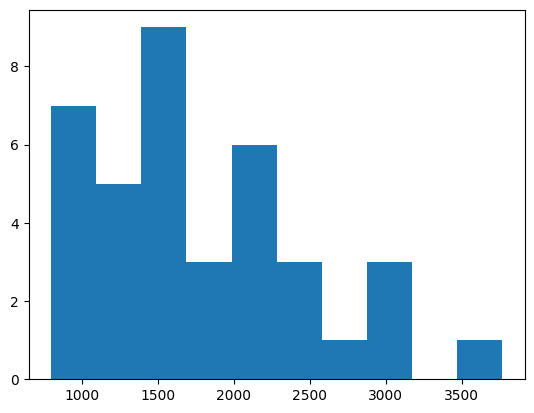

In [141]:
print(np.mean(n/cos**(1/2)),np.std(n/cos**(1/2)))
plt.hist(n/cos**(1/2))

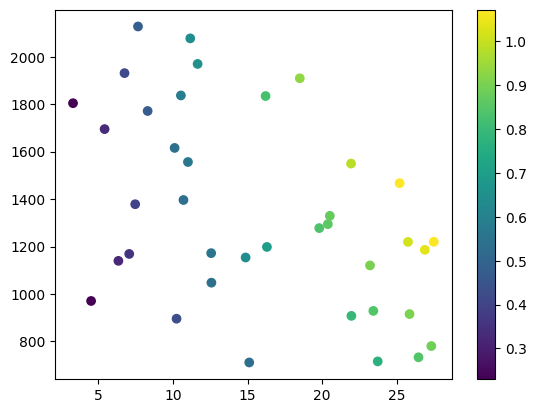

In [144]:
plt.scatter(HST['Sep'][Glo],n,c=cos)
plt.colorbar()

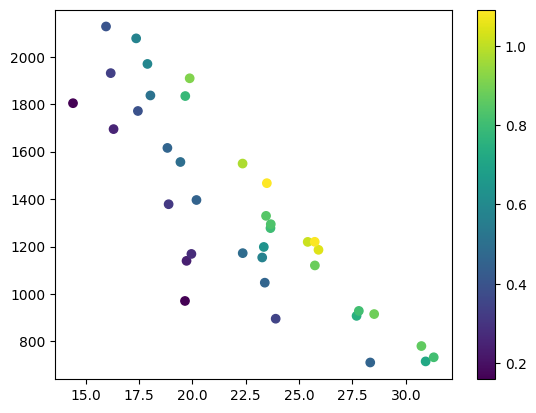

In [155]:
cos1 = np.sqrt(Pg/Pr)
plt.scatter(R,n,c=cos1)
plt.colorbar()

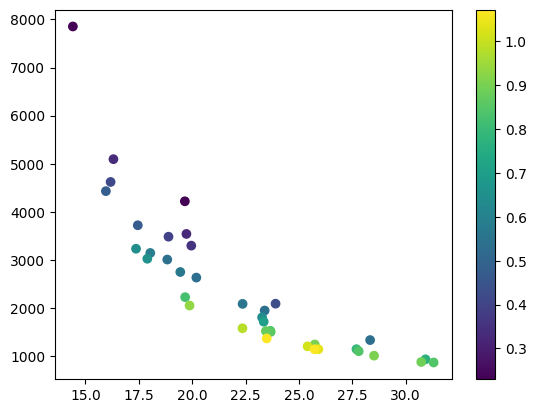

In [146]:
plt.scatter(R,n/cos,c=cos)
plt.colorbar()

Aqui vemos como afecta si consideramos que la densidad cae con el angulo o no.

Si consideramos que la densidad es igual en todas partes, entonces vemos que esto es como una función lineal con respecto a la 'distancia real', por otro lado vemos que si consideramos que la densidad cae con el angulo entonces este tiene otra dependencia con la distrancia en la cual tenemos densidades aun mayores.

Para el globulo más cercano tenemos un ángulo de inclinación muy grande, lo cual podria estar mal ya que en los otros globulos que le siguen vemos como su densidad cae mucho.

Al parecer no se encontró relación con $Hshell$, $Rshell$ o $Rcore$

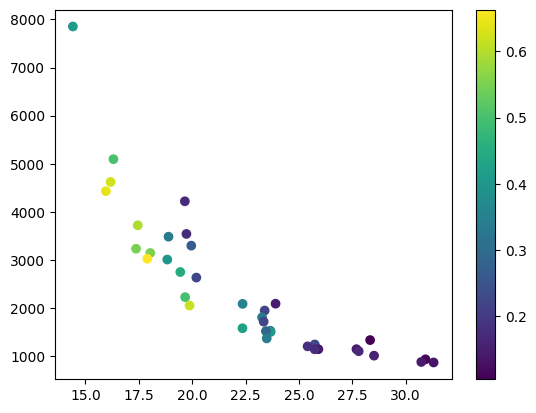

In [153]:
plt.scatter(R,n/cos,c=Bs)
plt.colorbar()

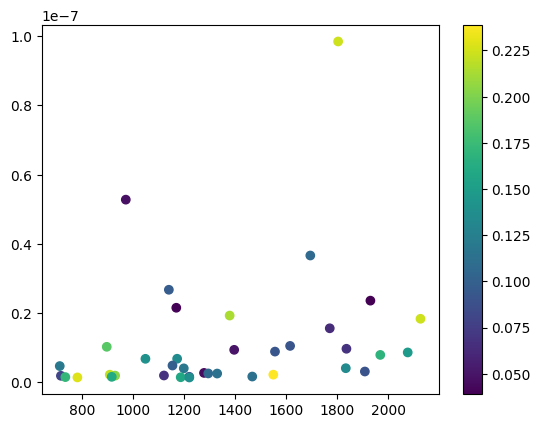

In [188]:
plt.scatter(n,Pr,c=r_CJ[Glo])
plt.colorbar()

In [158]:
HST['Lat']

<Angle [71.28154312, 21.86928602, 14.08097049, 26.9742229 , 28.17029005,
        12.69162072, 67.07676436,  4.97798786, 16.95834578, 37.48444338,
        33.07361379, 23.18431242, 25.60083534, 39.79698468, 48.17133983,
         3.37459491, 75.0986562 ,  5.94002415, 45.75377199,  5.93211817,
        49.99472588, 74.87814678, 48.97924325, 27.61924848, 39.99275763,
        47.53688531, 50.87922093, 17.74723171, 22.27305895, 45.7134575 ,
        64.95980004, 32.22421591,  2.3030267 , 17.40592589,  1.87361718,
        21.87985882,  0.85442594,  6.34545243, 28.31076386, 38.61299653,
        55.4274255 , 37.0497745 , 68.30026818, 38.16300182, 42.3562101 ,
        20.43601188,  9.69866732, 45.41957403, 15.88226378, 57.68966912,
        46.89383432, 11.19369802,  4.56698473, 45.34716686, 58.44816201,
        51.48007052, 14.54806744, 45.37146031, 40.42032881, 11.58954301,
         9.19465885,  9.13071033, 16.44543077, 52.06037753, 28.77524771,
        64.45503844, 28.77759984, 17.12136556, 13.5

In [218]:
et = [
    n,Bs,HST['Bbg'][Glo],r_CJ[Glo],R1,H,HST['Lat'][Glo],Pg,Pr,cos,R
]
et_n = [
    'n','Bs','Bbg','r_C','R1','H','Lat','Pg','Pr','cos','R'
]

In [226]:
#fig = plt.figure(figsize=(23, 23))
def Crea(x1,x2):
    print(et_n[x1],et_n[x2])
    fig = plt.figure(figsize=(23, 23))
    nu = []
    nom = []
    for i in range(len(et)):
        if (x1 != i) & (x2!=i):
            nu.append(i)
            nom.append(et_n[i])

    for idx in range(len(nu)):
        ax = fig.add_subplot(3, 3, idx + 1)
        w = et[nu[idx]]
        ax.scatter(et[x1],et[x2],c=w)
        ax.text(0.05, 0.95, rf'w = {nom[idx]}', transform=ax.transAxes, va="top", ha="left")
        #ax.colorbar()

n R


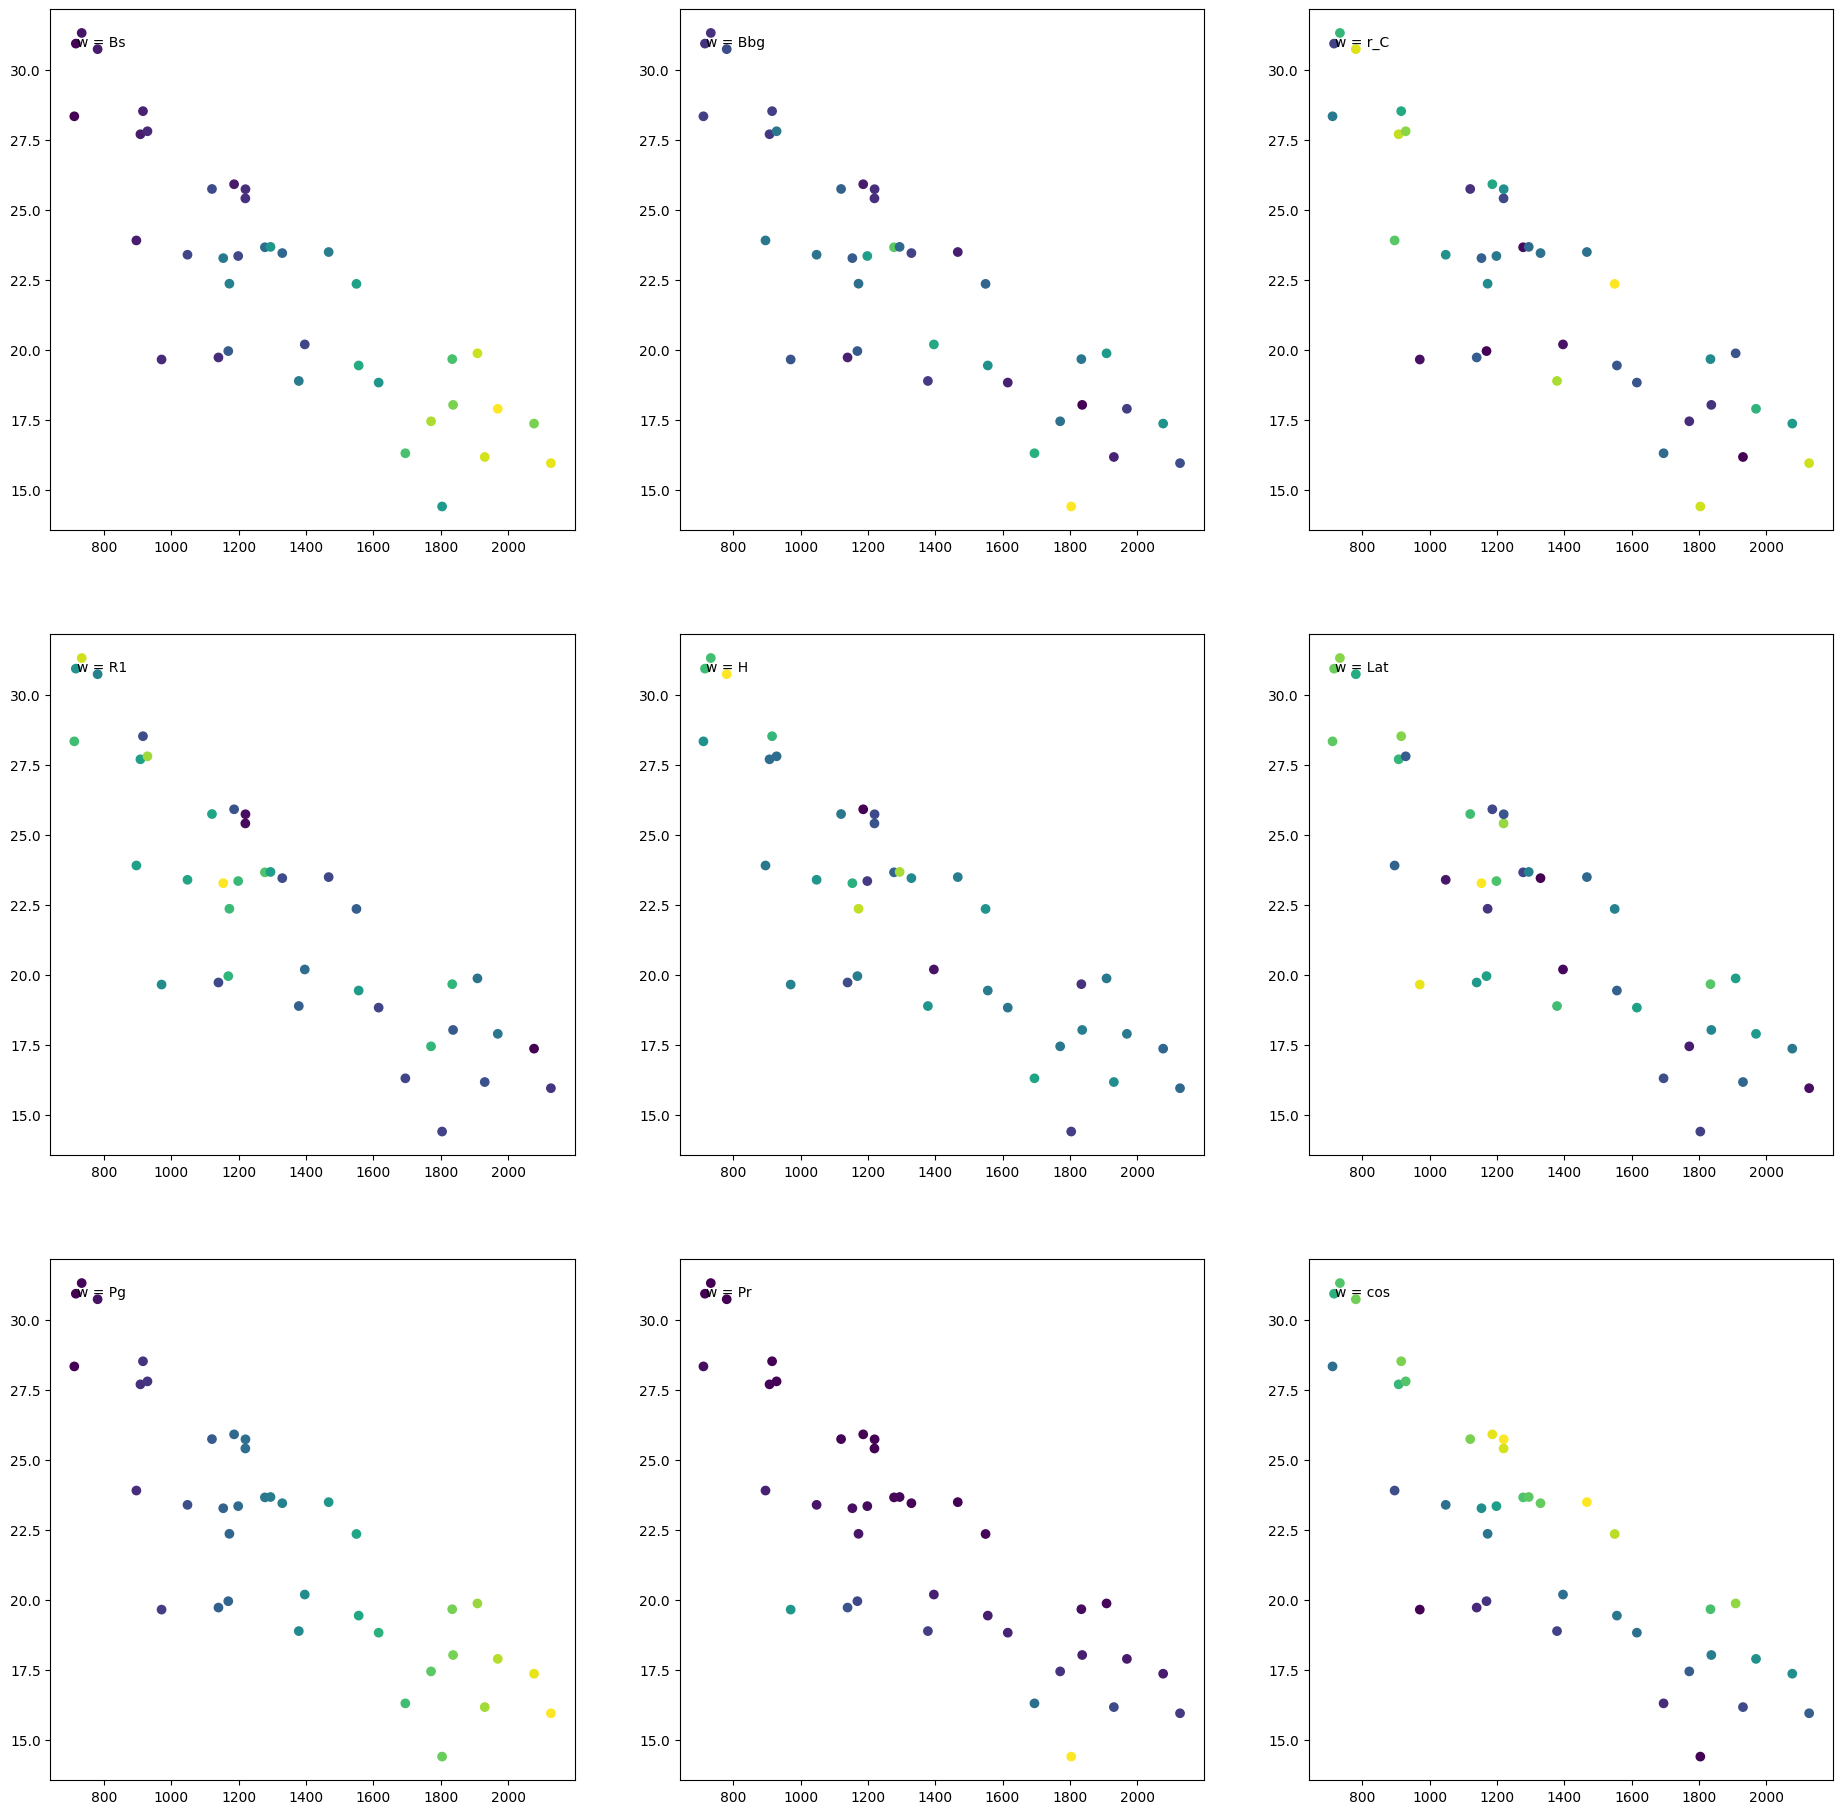

In [293]:
Crea(0,10)

In [211]:
1!=0

True

(array([ 2.,  3.,  3.,  8., 10.,  5.,  4.,  0.,  1.,  2.]),
 array([0.09184153, 0.12708426, 0.16232698, 0.1975697 , 0.23281242,
        0.26805514, 0.30329786, 0.33854058, 0.3737833 , 0.40902603,
        0.44426875]),
 <BarContainer object of 10 artists>)

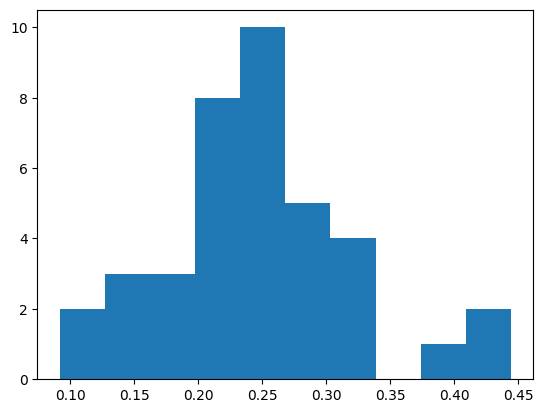

In [237]:
plt.hist(H)

In [238]:
add

[8, 11, 24, 31, 38, 71, 80, 117, 118, 138, 152]

In [245]:
H1 = []
for i in range(len(Glo)):
    if Glo[i] in add:
        hf = 2*np.sqrt(2*np.log(2))*H[i]
        h1 = np.sqrt(hf**2-(.145/2)**2)
        H1.append(h1)
    else:
        hf = 2*np.sqrt(2*np.log(2))*H[i]
        h1 = np.sqrt(hf**2-(.067/2)**2)
        H1.append(h1)

H1

[0.3648356264204654,
 0.5818389324086279,
 0.6958183320762837,
 0.40672911825866503,
 0.6145439867343028,
 0.5628124387081302,
 0.651625066795116,
 0.4928823133011102,
 0.5437236861868286,
 0.5385630993685951,
 0.5474462314258762,
 0.5633737945957249,
 0.25502136149197624,
 0.5613718523291354,
 0.48507536232827525,
 0.5545538980991179,
 0.9700496703478437,
 0.6465672521447325,
 0.7382549775593322,
 0.6339837293594766,
 0.3271601523231838,
 0.35395706928056103,
 0.5520842663735902,
 0.47925274131747286,
 0.9362879212970006,
 0.6027638511185072,
 0.6438902048393002,
 0.5088282238186709,
 0.5434440389447548,
 0.5099680942560662,
 0.7814545405950977,
 0.5679609871238883,
 0.4289420501422981,
 0.7682420834547791,
 0.7936565546079409,
 0.20375619537256934,
 1.0456364516770065,
 0.40074763233596084]

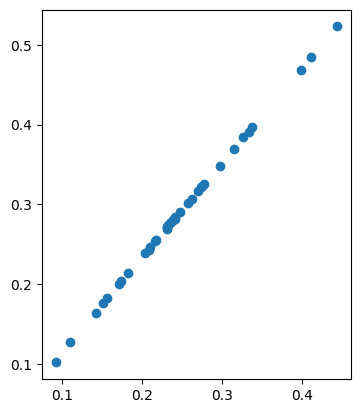

In [249]:
plt.scatter(H,np.array(H1)/2)
plt.gca().set_aspect('equal')

/home/rreyes/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


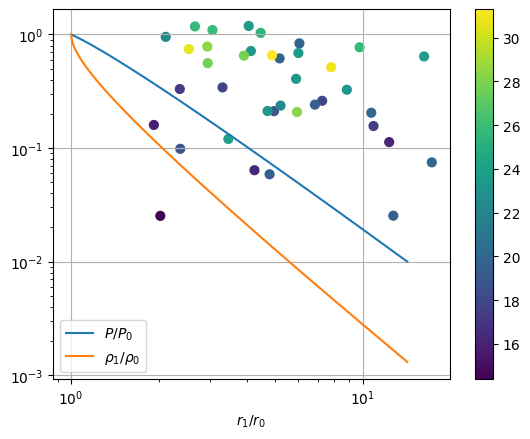

In [296]:
from scipy.optimize import fsolve

def find_root(x):
    """Should be called with vector argument of same length as P_P_0"""
    return ((1+x**2)/2)*(np.e**((1-x**2)/2)) - P_P0 #equation to find the root

#M0 = fsolve(func_to_find_M0, 1.5 * np.ones_like(P_P_0)) 

P_P0 = np.arange(0.01,1.01,0.01)
M0 = fsolve(find_root,1.5 * np.ones_like(P_P0))
alpha=2      #spherical case
rho1 = np.exp((1-M0**2)/2)
r1 = (M0**(-1/alpha))*np.exp((M0**2-1)/(2*alpha))
rho2 = (M0**2)*rho1
h2 = (3/(4*M0**2)) * r1

plt.plot(r1,P_P0,label=r'$P/P_0$')
plt.plot(r1,rho1,label=r'$\rho_1/\rho_0$')

g = plt.scatter(R1/r_CJ[Glo],Pg/Pr,c=R,s=40)
plt.colorbar(g)
#plt.xlim(1,10)
#plt.ylim(0.001,15)

plt.xlabel(r'$r_1/r_0$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [297]:
len(Glo)

38

(array([2., 4., 5., 6., 2., 8., 4., 2., 2., 3.]),
 array([14.41213384, 16.10150806, 17.79088227, 19.48025648, 21.1696307 ,
        22.85900491, 24.54837912, 26.23775334, 27.92712755, 29.61650176,
        31.30587598]),
 <BarContainer object of 10 artists>)

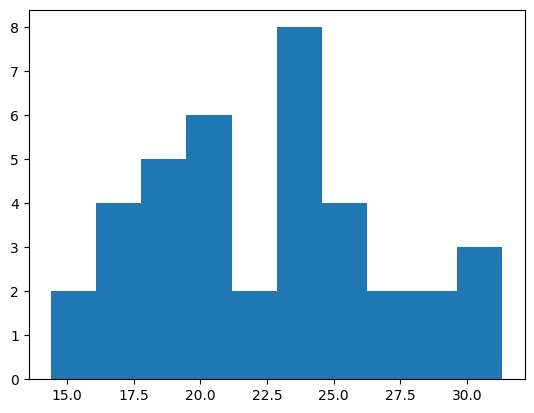

In [298]:
plt.hist(R)

(array([2., 4., 4., 6., 3., 2., 2., 8., 3., 4.]),
 array([0.22972479, 0.3139544 , 0.39818402, 0.48241363, 0.56664325,
        0.65087286, 0.73510248, 0.81933209, 0.9035617 , 0.98779132,
        1.07202093]),
 <BarContainer object of 10 artists>)

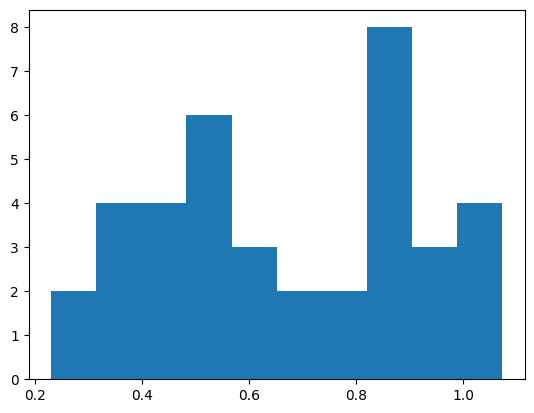

In [299]:
plt.hist(cos)